In [9]:
import pandas as pd
import numpy as np
import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from ErrorHandler import *
from data import load_ratebeer, DataErrorAdder
# import tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# import LinearRegression
from sklearn.linear_model import LinearRegression
# import RandomForestRegressor
# import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.dummy import DummyClassifier, DummyRegressor

def get_final_columns(column_transformer):
    """
    Iterate through ColumnTransformer to get the final transformed column names.
    - If it is OneHotEncoder, calculate categories and get new column names
    - For other transformers, keep the original column names
    """
    final_columns = []
    # column_transformer.fit(df)
    for name, pipeline, columns in column_transformer.transformers_:
        isOnehot = False
        isBert = False
        for transformer in pipeline:
            if isinstance(transformer, OneHotEncoder):
                isOnehot = True
            if isinstance(transformer, BERTEmbeddingTransformer2):
                isBert = True
        if isOnehot:
            # OneHotEncoder
            print(columns)
            if len(columns) != 0:
                for col in columns:
                    unique_categories = [list(set(A[i].unique())-{None, np.nan}) for i in [col]][0]
                    print("unique_categories", len(unique_categories))
                    generated_col_names = [f"{col}_{category}" for category in unique_categories]
                    final_columns.extend(generated_col_names)

        elif isBert:
            # for BERT transformer, keep original column names
            if len(columns) != 0:
                col = columns[0]
                extended_columns = [f"{col}_{i}" for i in range(768)]
                final_columns.extend(extended_columns)
        else:
            print("columns", columns)
            # for other transformers, keep original column names
            final_columns.extend(columns if isinstance(columns, list) else [columns])
        print("final_columns", final_columns)
    return final_columns




In [10]:

A = load_ratebeer("sampled_dataframe2.csv")
# shuffle A
A = A.sample(frac=1, random_state=42).reset_index(drop=True)
B = A.copy()
# add error
error_adder = DataErrorAdder("config0.yaml")
B = error_adder.add_errors(B)
C = B.copy()


num_data = 5000
A = A.head(num_data)
B = B.head(num_data)
C = C.head(num_data)


numerical_cols = ["review/appearance", "review/aroma", "review/palate", "review/taste"]
target_col = "review/overall"
categorical_cols = []
text_cols = ["review/text"]


# text_cols = []
# keep only the columns that are used
A = A[[target_col] + numerical_cols + categorical_cols + text_cols]
B = B[[target_col] + numerical_cols + categorical_cols + text_cols]
C = C[[target_col] + numerical_cols + categorical_cols + text_cols]


# pipeline for A
preprocessor_A = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("missing_values", MissingValueChecker(data_type="numerical", strategy="drop")),
            # ("bound_constrain", OutOfBoundsChecker(lower_bound=0)),
            # ("outliers", OutlierHandler(strategy="clip")),
            ("normalizer", ScaleAdjust(method="standard")),
            ("align_index", AlignTransformer(original_index=A.index)),
        ]), numerical_cols),

        ("cat", Pipeline([
            ("missing_values", MissingValueChecker(data_type="categorical", strategy="drop")),
            ("align_index", AlignTransformer(original_index=A.index)),
            ("onehot", OneHotEncoder(categories=[list(set(A[i].unique())-{None, np.nan}) for i in categorical_cols], handle_unknown="ignore"))
        ]), categorical_cols),

        ("text", Pipeline([
            # ("gibberish", GibberishDetector(method="ngram")),
            ("bert_embedding", BERTEmbeddingTransformer2()),
            # ("tf_idf", TfidfVectorizer()),
            ("align_index", AlignTransformer(original_index=A.index)),
            ("missing_text", MissingValueChecker(data_type="numerical", strategy="drop")),
            ("align_index2", AlignTransformer(original_index=A.index)),
        ]), text_cols),
    ],
    remainder="drop"
)


# pipeline for B
preprocessor_B = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("missing_values", MissingValueChecker(data_type="numerical", strategy="drop")),
            # ("bound_constrain", OutOfBoundsChecker(lower_bound=0)),
            # ("outliers", OutlierHandler(strategy="clip")),
            ("normalizer", ScaleAdjust(method="standard")),
            ("align_index", AlignTransformer(original_index=B.index)),
        ]), numerical_cols),

        ("cat", Pipeline([
            ("missing_values", MissingValueChecker(data_type="categorical", strategy="drop")),
            ("align_index", AlignTransformer(original_index=B.index)),
            ("onehot", OneHotEncoder(categories=[list(set(B[i].unique())-{None, np.nan}) for i in categorical_cols], handle_unknown="ignore"))
        ]), categorical_cols),

        ("text", Pipeline([
            # ("gibberish", GibberishDetector(method="ngram")),
            ("bert_embedding", BERTEmbeddingTransformer2()),
            # ("tf_idf", TfidfVectorizer()),
            ("align_index", AlignTransformer(original_index=B.index)),
            ("missing_text", MissingValueChecker(data_type="numerical", strategy="drop")),
            ("align_index2", AlignTransformer(original_index=B.index)),
        ]), text_cols),
    ],
    remainder="drop"
)

# pipeline for C
preprocessor_C = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("missing_values", MissingValueChecker(data_type="numerical", strategy="mean")),
            ("bound_constrain", OutOfBoundsChecker(lower_bound=0)),
            ("outliers", OutlierHandler(strategy="clip")),
            ("normalizer", ScaleAdjust(method="standard")),
            ("align_index", AlignTransformer(original_index=C.index)),
        ]), numerical_cols),

        ("cat", Pipeline([
            ("missing_values", MissingValueChecker(data_type="categorical", strategy="most_common")),
            ("align_index", AlignTransformer(original_index=C.index)),
            ("onehot", OneHotEncoder(categories=[list(set(C[i].unique())-{None, np.nan}) for i in categorical_cols], handle_unknown="ignore"))
        ]), categorical_cols),

        ("text", Pipeline([
            # ("gibberish", GibberishDetector(method="ngram")),
            ("gibberish", TwoStepGibberishDetector()),
            ("bert_embedding", BERTEmbeddingTransformer2()),
            # ("tf_idf", TfidfVectorizer()),
            ("align_index", AlignTransformer(original_index=C.index)),
            ("missing_text", MissingValueChecker(data_type="numerical", strategy="most_common")),
            ("align_index2", AlignTransformer(original_index=C.index)),
        ]), text_cols),
    ],
    remainder="drop"
)


# pipeline for A
pipeline_A = Pipeline([
    ("preprocessor", preprocessor_A),
    ("to_df", FunctionTransformer(lambda X: pd.DataFrame(X))),
    ("dropper", MissDropper()),
])

# pipeline for B
pipeline_B = Pipeline([
    ("preprocessor", preprocessor_B),
    ("to_df", FunctionTransformer(lambda X: pd.DataFrame(X))),
    ("dropper", MissDropper()),
])

# pipeline for C
pipeline_C = Pipeline([
    ("preprocessor", preprocessor_C),
    ("to_df", FunctionTransformer(lambda X: pd.DataFrame(X))),
    ("dropper", MissDropper()),
])

# train a model
np.random.seed(42)

Model 'lid.176.bin' already exists.


[nltk_data] Downloading package words to /Users/caleb/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:

X_A = A.drop(columns=[target_col])
y_A = A[target_col]
X_B = B.drop(columns=[target_col])  
y_B = B[target_col]
X_C = C.drop(columns=[target_col])
y_C = C[target_col]

# X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y_A, test_size=0.2, random_state=42)
# X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B, test_size=0.2, random_state=42)
# X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_C, test_size=0.2, random_state=42)

print("==========A transform==========")
X_A = pipeline_A.fit_transform(X_A)
y_A = y_A.loc[X_A.index]
print("==========B transform==========")
X_B = pipeline_B.fit_transform(X_B)
y_B = y_B.loc[X_B.index]
print("==========C transform==========")
X_C = pipeline_C.fit_transform(X_C)
y_C = y_C.loc[X_C.index]



print("==========split dataset==========")

# get totle rows
total_rows = X_B.shape[0]
num_index_for_train = int(total_rows * 0.8)

# split the dataset
X_A_train, X_A_test, y_A_train, y_A_test = X_A.iloc[:num_index_for_train], X_A.iloc[num_index_for_train:], y_A.iloc[:num_index_for_train], y_A.iloc[num_index_for_train:]
X_B_train, X_B_test, y_B_train, y_B_test = X_B.iloc[:num_index_for_train], X_B.iloc[num_index_for_train:], y_B.iloc[:num_index_for_train], y_B.iloc[num_index_for_train:]
X_C_train, X_C_test, y_C_train, y_C_test = X_C.iloc[:num_index_for_train], X_C.iloc[num_index_for_train:], y_C.iloc[:num_index_for_train], y_C.iloc[num_index_for_train:]


# X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y_A, test_size=0.2, random_state=42, shuffle=False)
# X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B, test_size=0.2, random_state=42, shuffle=False)
# X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_C, test_size=0.2, random_state=42, shuffle=False)

# model_A = DecisionTreeRegressor(random_state=42)
# model_B = DecisionTreeRegressor(random_state=42)
# model_C = DecisionTreeRegressor(random_state=42)

# X_A_train.head(10), X_B_train.head(10), X_C_train.head(10), y_A_train.head(10), y_B_train.head(10), y_C_train.head(10), X_A_test.head(10), X_B_test.head(10), X_C_test.head(10), y_A_test.head(10), y_B_test.head(10), y_C_test.head(10)

==========A transform==========


Token indices sequence length is longer than the specified maximum sequence length for this model (1056 > 512). Running this sequence through the model will result in indexing errors
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processing batches: 100%|██████████| 79/79 [00:27<00:00,  2.85it/s]


==========B transform==========


Token indices sequence length is longer than the specified maximum sequence length for this model (1056 > 512). Running this sequence through the model will result in indexing errors
Processing batches: 100%|██████████| 79/79 [00:23<00:00,  3.31it/s]


==========C transform==========
Model 'lid.176.bin' already exists.


[nltk_data] Downloading package words to /Users/caleb/nltk_data...
[nltk_data]   Package words is already up-to-date!
Token indices sequence length is longer than the specified maximum sequence length for this model (1056 > 512). Running this sequence through the model will result in indexing errors
Processing batches: 100%|██████████| 77/77 [00:24<00:00,  3.12it/s]


==========split dataset==========


In [12]:

model_A = RandomForestRegressor(random_state=42)
model_B = RandomForestRegressor(random_state=42)
model_C =  RandomForestRegressor(random_state=42)
print("==========fit model==========")
model_A.fit(X_A_train, y_A_train)
model_B.fit(X_B_train, y_B_train)
model_C.fit(X_C_train, y_C_train)

print("==========predict model==========")
# model on dataset
y_A_on_A = model_A.predict(X_A_test)
y_A_on_B = model_A.predict(X_B_test)
y_A_on_C = model_A.predict(X_C_test)
y_B_on_A = model_B.predict(X_A_test)
y_B_on_B = model_B.predict(X_B_test)
y_B_on_C = model_B.predict(X_C_test)
y_C_on_A = model_C.predict(X_A_test)
y_C_on_B = model_C.predict(X_B_test)
y_C_on_C = model_C.predict(X_C_test)



==========fit model==========
==========predict model==========


In [13]:

print("==========calculate errors==========")
mse_A_on_A = mean_squared_error(y_A_test, y_A_on_A)
mae_A_on_A = mean_absolute_error(y_A_test, y_A_on_A)
r2_A_on_A = r2_score(y_A_test, y_A_on_A)

mse_A_on_B = mean_squared_error(y_B_test, y_A_on_B)
mae_A_on_B = mean_absolute_error(y_B_test, y_A_on_B)
r2_A_on_B = r2_score(y_B_test, y_A_on_B)

mse_A_on_C = mean_squared_error(y_C_test, y_A_on_C)
mae_A_on_C = mean_absolute_error(y_C_test, y_A_on_C)
r2_A_on_C = r2_score(y_C_test, y_A_on_C)

mse_B_on_A = mean_squared_error(y_A_test, y_B_on_A)
mae_B_on_A = mean_absolute_error(y_A_test, y_B_on_A)
r2_B_on_A = r2_score(y_A_test, y_B_on_A)

mse_B_on_B = mean_squared_error(y_B_test, y_B_on_B)
mae_B_on_B = mean_absolute_error(y_B_test, y_B_on_B)
r2_B_on_B = r2_score(y_B_test, y_B_on_B)

mse_B_on_C = mean_squared_error(y_C_test, y_B_on_C)
mae_B_on_C = mean_absolute_error(y_C_test, y_B_on_C)
r2_B_on_C = r2_score(y_C_test, y_B_on_C)

mse_C_on_A = mean_squared_error(y_A_test, y_C_on_A)
mae_C_on_A = mean_absolute_error(y_A_test, y_C_on_A)
r2_C_on_A = r2_score(y_A_test, y_C_on_A)

mse_C_on_B = mean_squared_error(y_B_test, y_C_on_B)
mae_C_on_B = mean_absolute_error(y_B_test, y_C_on_B)
r2_C_on_B = r2_score(y_B_test, y_C_on_B)

mse_C_on_C = mean_squared_error(y_C_test, y_C_on_C)
mae_C_on_C = mean_absolute_error(y_C_test, y_C_on_C)
r2_C_on_C = r2_score(y_C_test, y_C_on_C)



print("==========result of A on A==========")
print(f"Mean Squared Error: {mse_A_on_A:.2f}")
print(f"Mean Absolute Error: {mae_A_on_A:.2f}")
print(f"R^2 Score: {r2_A_on_A:.2f}")

print("==========result of A on B==========")
print(f"Mean Squared Error: {mse_A_on_B:.2f}")
print(f"Mean Absolute Error: {mae_A_on_B:.2f}")
print(f"R^2 Score: {r2_A_on_B:.2f}")

print("==========result of A on C==========")
print(f"Mean Squared Error: {mse_A_on_C:.2f}")
print(f"Mean Absolute Error: {mae_A_on_C:.2f}")
print(f"R^2 Score: {r2_A_on_C:.2f}")

print("==========result of B on A==========")
print(f"Mean Squared Error: {mse_B_on_A:.2f}")
print(f"Mean Absolute Error: {mae_B_on_A:.2f}")
print(f"R^2 Score: {r2_B_on_A:.2f}")

print("==========result of B on B==========")
print(f"Mean Squared Error: {mse_B_on_B:.2f}")
print(f"Mean Absolute Error: {mae_B_on_B:.2f}")
print(f"R^2 Score: {r2_B_on_B:.2f}")

print("==========result of B on C==========")
print(f"Mean Squared Error: {mse_B_on_C:.2f}")
print(f"Mean Absolute Error: {mae_B_on_C:.2f}")
print(f"R^2 Score: {r2_B_on_C:.2f}")

print("==========result of C on A==========")
print(f"Mean Squared Error: {mse_C_on_A:.2f}")
print(f"Mean Absolute Error: {mae_C_on_A:.2f}")
print(f"R^2 Score: {r2_C_on_A:.2f}")

print("==========result of C on B==========")
print(f"Mean Squared Error: {mse_C_on_B:.2f}")
print(f"Mean Absolute Error: {mae_C_on_B:.2f}")
print(f"R^2 Score: {r2_C_on_B:.2f}")

print("==========result of C on C==========")
print(f"Mean Squared Error: {mse_C_on_C:.2f}")
print(f"Mean Absolute Error: {mae_C_on_C:.2f}")
print(f"R^2 Score: {r2_C_on_C:.2f}")

==========calculate errors==========
==========result of A on A==========
Mean Squared Error: 2.42
Mean Absolute Error: 1.18
R^2 Score: 0.86
==========result of A on B==========
Mean Squared Error: 2.54
Mean Absolute Error: 1.22
R^2 Score: 0.86
==========result of A on C==========
Mean Squared Error: 2.56
Mean Absolute Error: 1.22
R^2 Score: 0.86
==========result of B on A==========
Mean Squared Error: 2.78
Mean Absolute Error: 1.28
R^2 Score: 0.84
==========result of B on B==========
Mean Squared Error: 2.44
Mean Absolute Error: 1.20
R^2 Score: 0.86
==========result of B on C==========
Mean Squared Error: 2.44
Mean Absolute Error: 1.20
R^2 Score: 0.86
==========result of C on A==========
Mean Squared Error: 2.47
Mean Absolute Error: 1.20
R^2 Score: 0.86
==========result of C on B==========
Mean Squared Error: 2.36
Mean Absolute Error: 1.18
R^2 Score: 0.87
==========result of C on C==========
Mean Squared Error: 2.41
Mean Absolute Error: 1.18
R^2 Score: 0.86


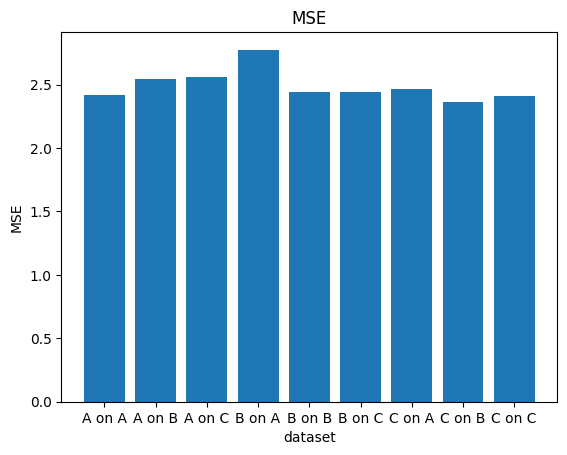

In [14]:
# draw mse graph
import matplotlib.pyplot as plt

mse = [mse_A_on_A, mse_A_on_B, mse_A_on_C, mse_B_on_A, mse_B_on_B, mse_B_on_C, mse_C_on_A, mse_C_on_B, mse_C_on_C]

# draw mse graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("MSE")
ax.set_xlabel("dataset")
ax.set_ylabel("MSE")
ax.bar(["A on A", "A on B", "A on C", "B on A", "B on B", "B on C", "C on A", "C on B", "C on C"], mse)
plt.show()


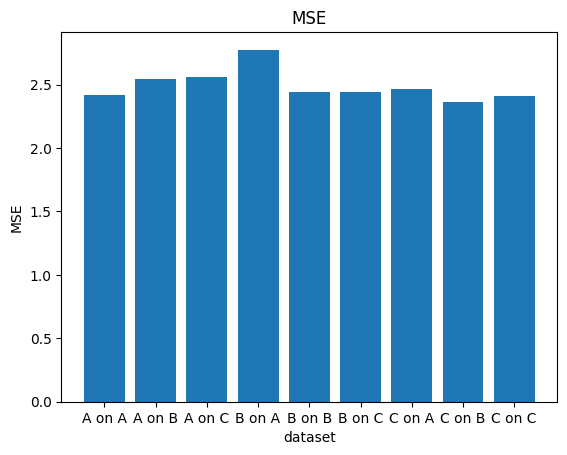

In [15]:
# draw mse graph
import matplotlib.pyplot as plt

mse = [mse_A_on_A, mse_A_on_B, mse_A_on_C, mse_B_on_A, mse_B_on_B, mse_B_on_C, mse_C_on_A, mse_C_on_B, mse_C_on_C]

# draw mse graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("MSE")
ax.set_xlabel("dataset")
ax.set_ylabel("MSE")
ax.bar(["A on A", "A on B", "A on C", "B on A", "B on B", "B on C", "C on A", "C on B", "C on C"], mse)
plt.show()
